In [1]:
# Import library
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
!pip install vnstock
from vnstock import *

In [2]:
# Import data
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
VND
#VND["Close"].plot()

Observations:  1630


,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2017-06-01,3200,3250,3200,3230,167483,VND
2017-06-02,3230,3330,3200,3280,411631,VND
2017-06-05,3320,3370,3270,3280,671582,VND
2017-06-06,3280,3320,3270,3320,174560,VND
2017-06-07,3320,3610,3320,3590,2332950,VND
...,...,...,...,...,...,...
2023-12-11,21700,22050,21400,21950,24142900,VND
2023-12-12,22000,22300,22000,22050,16260700,VND
2023-12-13,22250,22350,21500,21600,21677300,VND


In [3]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
def preprocessing(data):
    df = data[["Close", "Open"]]
    df = df.reset_index(drop = True)
    df['Close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))
    df['Open'] = scaler.transform(np.array(df['Open']).reshape(-1,1))
    print(df)
    return df

def SplitSet73(data):
    train_size = int(0.7*len(data))
    test_size = int(0.3*len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    print("Train data:\n", train_data.shape)
    print("Test data: \n", test_data.shape)
    return train_size, test_size, train_data, test_data
    

In [4]:
df = preprocessing(VND)

         Close      Open
0     0.021705  0.020775
1     0.023256  0.021705
2     0.023256  0.024496
3     0.024496  0.023256
4     0.032868  0.024496
...        ...       ...
1625  0.602171  0.594419
1626  0.605271  0.603721
1627  0.591318  0.611473
1628  0.586667  0.602171
1629  0.597519  0.586667

[1630 rows x 2 columns]


In [5]:
train_size = int(len(df)- 60)
test_size = int(60)
train_data = df[:train_size]
test_data = df[train_size+1:]
print("Train data:\n", train_data.shape)
print("Test data: \n", test_data.shape)

Train data:
 (1570, 2)
Test data: 
 (59, 2)


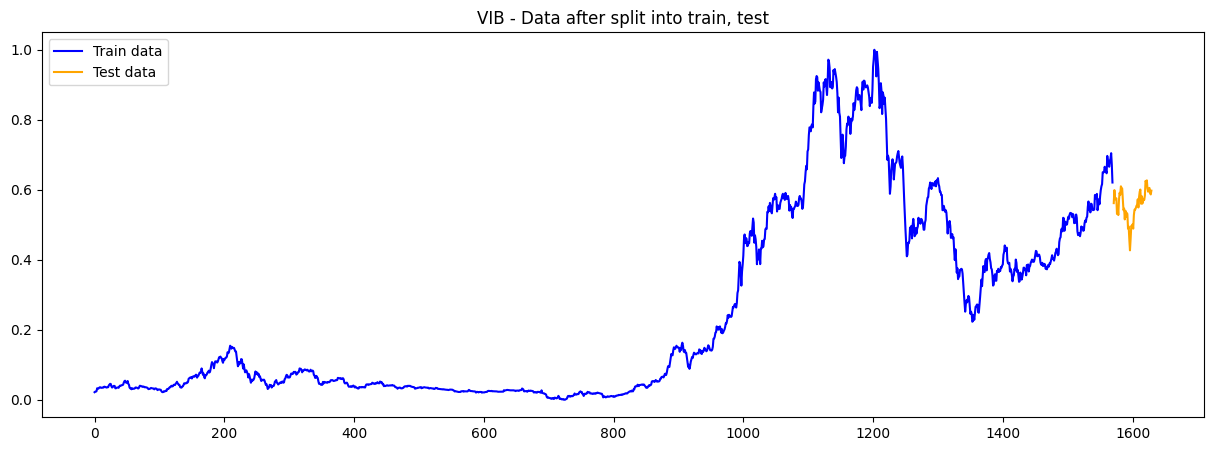

In [6]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Close'], 'b')
plt.plot(test_data.index, test_data['Close'], 'orange')
plt.legend(['Train data', 'Test data'], loc='upper left')
plt.title('VIB - Data after split into train, test')
plt.show()

In [7]:
model_var = VAR(train_data)
for i in range(1,10):
    results = model_var.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  -18.798026453508644
BIC:  -18.7775362288328

Order = 2
AIC:  -18.845110373802946
BIC:  -18.810942285786936

Order = 3
AIC:  -18.842055816135964
BIC:  -18.794195665917083

Order = 4
AIC:  -18.84832752210751
BIC:  -18.786761086744857

Order = 5
AIC:  -18.856292262943562
BIC:  -18.781005295361812

Order = 6
AIC:  -18.864684211390664
BIC:  -18.775662440323696

Order = 7
AIC:  -18.860718107044754
BIC:  -18.75794723697908

Order = 8
AIC:  -18.861552233824465
BIC:  -18.74501794494253

Order = 9
AIC:  -18.86795371951386
BIC:  -18.73764166763712



In [8]:
result = model_var.fit(7)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Dec, 2023
Time:                     17:47:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.7579
Nobs:                     1563.00    HQIC:                  -18.8225
Log likelihood:           10334.0    FPE:                6.44013e-09
AIC:                     -18.8607    Det(Omega_mle):     6.31828e-09
--------------------------------------------------------------------
Results for equation Close
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000679         0.000463            1.469           0.142
L1.Close         1.019220         0.027010           37.735           0.000
L1.Open          0.326439         0.058935            5.539           0.000
L2.C

In [9]:
lags_order = result.k_ar
lags_order

7

In [10]:
#Predict the price
y_pred_test = []
for i in range(test_data.shape[0] - lags_order):
    forecast_input = test_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_test.append(list(pred[0]))

y_pred_test_price = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[0].reshape(-1, 1)))
y_pred_test_vol = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[1].reshape(-1, 1)))
y_pred_test_price.shape

(52, 1)

In [11]:
number_of_days_to_predict = 60

In [12]:
ndays_pred = result.forecast(df[-lags_order-number_of_days_to_predict:-number_of_days_to_predict].values, steps=number_of_days_to_predict)
ndays_pred = np.array(ndays_pred)[:, 0]
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))

ndays_pred.shape

(60, 1)

In [13]:
y_test = test_data['Close'].values[lags_order:]
y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
y_test.shape

(52, 1)

In [15]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100

print("RSME test :", RSME(y_pred_test_price, y_test))
print("MAE test : ", MAE(y_pred_test_price, y_test))
print("MAPE test: ", MAPE(y_pred_test_price, y_test))

RSME test : 715.871798993865
MAE test :  573.2717279904193
MAPE test:  2.86718508909574


In [16]:
lags = lags_order - 1

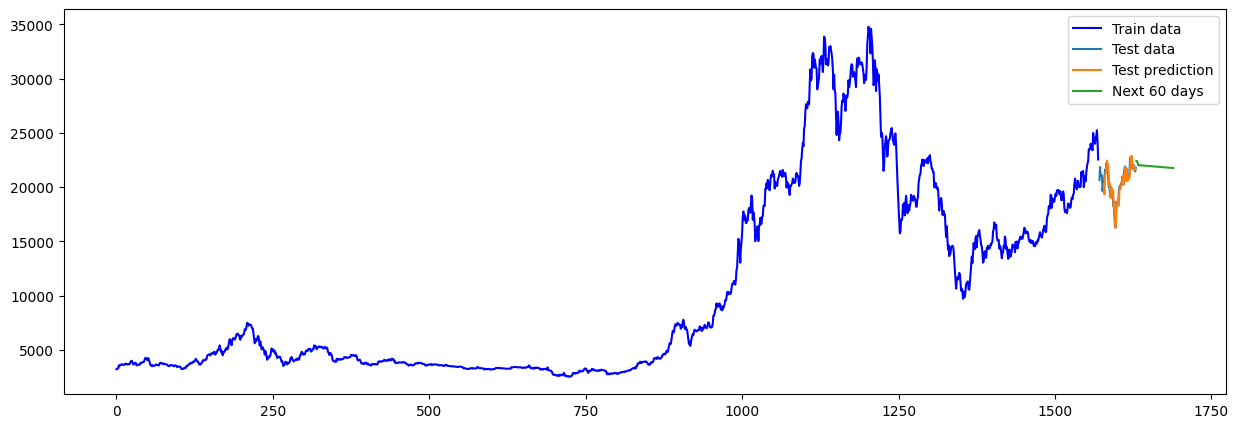

In [17]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, scaler.inverse_transform(np.array(train_data['Close']).reshape(-1, 1)), color="blue")
plt.plot(test_data.index, scaler.inverse_transform(np.array(test_data['Close']).reshape(-1, 1)).reshape(-1, 1))
plt.plot(test_data.index[-len(y_pred_test_price):], y_pred_test_price)
pred_ind = pd.RangeIndex(start = len(df['Close']), stop = len(df['Close'])+60)
plt.plot(pred_ind, ndays_pred)

plt.legend(["Train data", "Test data", "Test prediction", "Next 60 days"])
plt.show()